##PPGC - UFPEL
##2024/1 - 1110076 - 1 - TÓPICOS ESPECIAIS EM COMPUTAÇÃO IV - MINERAÇÃO DE DADOS EDUCACIONAIS

##Guilherme D. Lima - Mestrando em Computação

##Descrição da Atividade
Nesse exercício de programação, você deve resolver um problema de classificação,
incluindo validação-cruzada com conjunto de teste, assim como verificação de
overfitting/underfitting.

###1) Definição do Problema

Esse exercício de programação foi dado pelo professor Ryan Baker no MOOC Big Data
in Education, disponibilizado pela plataforma http://edx.org. Ryan Baker é um dos principais
pesquisadores na área de Mineração de Dados Educacionais, sendo um dos percursores no
uso de mineração de dados para predizer comportamentos e emoções de estudantes em
ambientes de aprendizagem inteligentes.
Nesse exercício, ele disponibiliza uma versão simplificada da base de dados usada no
artigo:

• GODWIN, K.E., ALMEDA, M.V., PETROCCIA, M., BAKER, R.S., & FISHER, A.V. (2013).

• CLASSROOM ACTIVITIES AND OFF-TASK BEHAVIOR IN ELEMENTARY SCHOOL CHILDREN.

• POSTER PAPER. PROCEEDINGS OF THE ANNUAL MEETING OF THE COGNITIVE
SCIENCE SOCIETY, 2428-2433.

O arquivo que contém a base de dados foi disponibilizado no e-aula e se chama “a1-
in.csv”. Também disponibilizei o artigo no e-aula.

Neste exercício, você utilizará a base de dados para prever comportamentos off-task e
on-task, indicados pela variável ONTASK (Y=Yes, N=No), configurando assim um problema de
classificação binária. O comportamento on-task, por exemplo, resolver um exercício no
ambiente de aprendizagem, ocorre quando os estudantes estão engajados e concentrados na
atividade de aprendizado proposta. Por outro lado, o comportamento off-task, como conversar
com colegas sobre assuntos não relacionados às atividades, navegar em conteúdo irrelevante
na internet ou adotar uma abordagem de tentativa e erro na resolução de exercícios, refere-se
a momentos em que os estudantes se distraem ou se envolvem em atividades alheias ao
aprendizado. A identificação desses comportamentos é fundamental para compreender e
aprimorar a eficácia dos ambientes educacionais.

### Bibliotecas

In [176]:
!pip install featuretools

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as srn
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import featuretools as ft

###2) Carregamento dos Dados

In [178]:
variable = 'a1-in.csv'
df = pd.read_csv(variable, delimiter=',')

######As variáveis preditoras relacionadas ao design instrucional incluíram a proporção de cada formato instrucional da sala de aula e a variável Transições/Duração do Formato Instrucional.

######O formato instrucional foi incluído como variável preditora para examinar se determinados formatos instrucionais elicitarão quantidades diferenciadas de comportamento fora de foco. Seis formatos instrucionais diferentes foram codificados: (1) trabalho individual, (2) trabalho em pequenos grupos ou em parceria, (3) instrução em grupo inteiro em mesas, (4) instrução em grupo inteiro enquanto sentados no tapete, (5) dança e (6) teste.


######Transições foram observadas toda vez que o professor pausava a instrução para mudar de uma atividade para outra (por exemplo, transição de resolver um problema de matemática para ouvir uma história curta). Em muitos casos, as transições coincidiam com uma mudança no formato instrucional (por exemplo, mudando de instrução em grupo inteiro para instrução em pequenos grupos); no entanto, isso nem sempre acontecia, já que as transições podiam ocorrer sem uma mudança no formato instrucional (por exemplo, com crianças girando de uma atividade de pequeno grupo para outra).

######A variável dependente primária foi a proporção de comportamento dentro de foco de um aluno específico dentro de uma sessão específica.

######O comportamento fora de foco baseado no ambiente foi de particular interesse, pois é um fator maleável que teoricamente poderia ser alvo de intervenções destinadas a mitigar o comportamento fora de foco.


#####E também os modelos que previram o comportamento dentro de foco foram ajustados com base no design instrucional e em características demográficas limitadas dos alunos (por exemplo, nível de série e gênero).

#####O Autor descre que para determinar comportamentos fora de foco, não parece ser importante se um aluno do ensino fundamental é menino ou menina, uma vez que o design instrucional é levado em consideração. Da mesma forma, o nível de série não parece ser um fator importante, uma vez que a influência do nível de série no design instrucional é considerada. Dentro do design instrucional, tanto o formato quanto a variável Transições/Duração do Formato Instrucional estavam associados a um modelo melhor. Remover qualquer um desses tipos de variáveis do modelo resultou em uma pior correlação validada cruzadamente.

#####A variável Transições/Duração do Formato Instrucional também foi encontrada com correlação positiva com o comportamento dentro de foco.

###3) Análise Descritiva

In [179]:
df.head(5)

,UNIQUEID,SCHOOL,Class,GRADE,CODER,STUDENTID,Gender,OBSNUM,totalobs-forsession,Activity,ONTASK,TRANSITIONS,NumACTIVITIES,FORMATchanges,NumFORMATS,Obsv/act,Transitions/Durations,Total Time
0,14400,B,T9Q,0,Z,600865,0,1,0,Wholecarpet,Y,3,4,1,2,770.5,0.004043,0
1,14401,B,T9Q,0,Z,596466,0,1,1,Wholecarpet,Y,3,4,1,2,770.5,0.004043,23
2,14402,B,T9Q,0,Z,616590,0,1,2,Wholecarpet,Y,3,4,1,2,770.5,0.004043,25
3,14403,B,T9Q,0,Z,734358,1,1,3,Wholecarpet,Y,3,4,1,2,770.5,0.004043,27
4,14404,B,T9Q,0,Z,826308,1,1,4,Wholecarpet,Y,3,4,1,2,770.5,0.004043,31


In [180]:
df.describe()

,UNIQUEID,GRADE,STUDENTID,Gender,OBSNUM,totalobs-forsession,TRANSITIONS,NumACTIVITIES,FORMATchanges,NumFORMATS,Obsv/act,Transitions/Durations,Total Time
count,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000,27731.000000
mean,28265.000000,2.060366,505973.490678,0.505644,9.613357,170.611049,2.381883,3.381883,1.535213,2.535213,975.087882,0.003181,773.006527
std,8005.394494,1.501447,283393.978714,0.499977,5.701109,105.780582,1.315171,1.315171,1.231694,1.231694,455.250539,0.010320,664.976978
min,14400.000000,0.000000,1123.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,387.000000,0.000000,0.000000
25%,21332.500000,1.000000,261495.000000,0.000000,5.000000,82.000000,1.000000,2.000000,1.000000,2.000000,721.200000,0.000839,251.000000
50%,28265.000000,2.000000,513716.000000,1.000000,9.000000,165.000000,2.000000,3.000000,1.000000,2.000000,876.250000,0.001521,586.000000
75%,35197.500000,4.000000,742667.000000,1.000000,14.000000,248.000000,3.000000,4.000000,2.000000,3.000000,1106.750000,0.003261,1116.000000
max,42130.000000,4.000000,999979.000000,1.000000,32.000000,511.000000,6.000000,7.000000,5.000000,6.000000,2735.000000,0.666667,3554.000000


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27731 entries, 0 to 27730
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UNIQUEID               27731 non-null  int64  
 1   SCHOOL                 27731 non-null  object 
 2   Class                  27731 non-null  object 
 3   GRADE                  27731 non-null  int64  
 4   CODER                  27731 non-null  object 
 5   STUDENTID              27731 non-null  int64  
 6   Gender                 27731 non-null  int64  
 7   OBSNUM                 27731 non-null  int64  
 8   totalobs-forsession    27731 non-null  int64  
 9   Activity               27731 non-null  object 
 10  ONTASK                 27731 non-null  object 
 11  TRANSITIONS            27731 non-null  int64  
 12  NumACTIVITIES          27731 non-null  int64  
 13  FORMATchanges          27731 non-null  int64  
 14  NumFORMATS             27731 non-null  int64  
 15  Ob

In [182]:
print(df.dtypes)

UNIQUEID                   int64
SCHOOL                    object
Class                     object
GRADE                      int64
CODER                     object
STUDENTID                  int64
Gender                     int64
OBSNUM                     int64
totalobs-forsession        int64
Activity                  object
ONTASK                    object
TRANSITIONS                int64
NumACTIVITIES              int64
FORMATchanges              int64
NumFORMATS                 int64
Obsv/act                 float64
Transitions/Durations    float64
Total Time                 int64
dtype: object


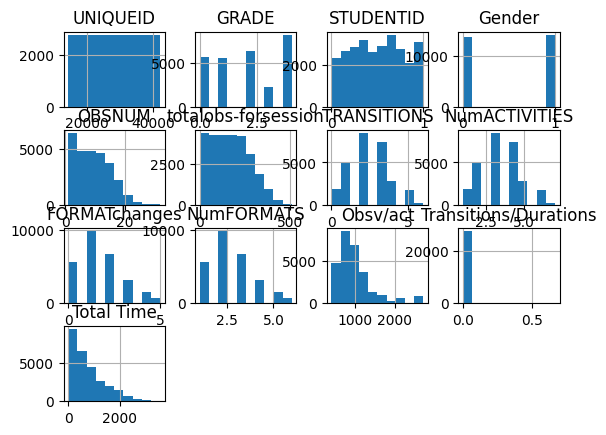

In [183]:
df.hist()
plt.show()

###4) Pré-Processamento

In [184]:
df.isnull().sum()

,0
UNIQUEID,0
SCHOOL,0
Class,0
GRADE,0
CODER,0
STUDENTID,0
Gender,0
OBSNUM,0
totalobs-forsession,0
Activity,0


In [185]:
df = df.drop_duplicates() # Removendo registros duplicados

#####Variaveis removidas:
* UNIQUEID

* Class

* STUDENTID

* OBSNUM
totalobs-forsession

* NumFORMATS

* SCHOOL

* Total Time

#####Variaveis Permaneceram:

* GRADE
* CODER
* Gender
* Activity
* ONTASK
* TRANSITIONS
* NumACTIVITIES
* FORMATchanges
* Obsv/act
* TransitionsDurations


As variáveis School e Class foram removidas porque ao treinar o modelo com esses valores, estaríamos tendenciando a predizer se o aluno está prestando atenção apenas no contexto da Escola e da Classe. Esse padrão também ocorreu com as demais variáveis selecionadas para remoção. Em contrapartida, as variáveis que permaneceram apresentam insights promissores para uma generalização precisa na predição do comportamento dos alunos em relação à atenção.

In [186]:
X = df.drop(['SCHOOL','UNIQUEID', 'Class', 'STUDENTID', 'OBSNUM', 'totalobs-forsession', 'NumFORMATS', 'Total Time','ONTASK'], axis=1)
y = pd.DataFrame({'ONTASK': [1 if ontask == 'Y' else 0 for ontask in df['ONTASK']]})

In [187]:
for column in X.columns:
    print(X.groupby(column).size())
    print()

GRADE
0    5636
1    5480
2    6271
3    2262
4    8082
dtype: int64

CODER
Y     1219
Z    26512
dtype: int64

Gender
0    13709
1    14022
dtype: int64

Activity
Dancing         143
Individual     5736
Smallgroup     5368
Testing         512
Wholecarpet    7044
Wholedesks     8928
dtype: int64

TRANSITIONS
0    1930
1    5096
2    8399
3    7389
4    2854
5    1803
6     260
dtype: int64

NumACTIVITIES
1    1930
2    5096
3    8399
4    7389
5    2854
6    1803
7     260
dtype: int64

FORMATchanges
0    5683
1    9846
2    6780
3    3199
4    1545
5     678
dtype: int64

Obsv/act
387.000000     266
399.285714     260
404.600000     399
448.200000     212
460.000000     437
              ... 
1808.000000    275
2076.000000    306
2181.000000    273
2530.000000    512
2735.000000    342
Length: 84, dtype: int64

Transitions/Durations
0.000000    1930
0.000404     268
0.000445     250
0.000446     294
0.000464     285
            ... 
0.100000       7
0.125000       5
0.181818       3
0

In [188]:
X['CODER'] = pd.DataFrame({'CODER': [0 if className == 'Y' else 1 for className in df['CODER']]})

X['Activity'] = pd.DataFrame({'Activity': [0 if className == 'Dancing' else
                             1 if className == 'Individual' else
                             2 if className == 'Smallgroup' else
                             3 if className == 'Testing' else
                             4 if className == 'Wholecarpet' else 5
                             for className in df['Activity']]})

In [189]:
X.groupby('CODER').size()

,0
CODER,
0,1219
1,26512


In [190]:
X.groupby('Activity').size()

,0
Activity,
0,143
1,5736
2,5368
3,512
4,7044
5,8928


In [191]:
y.head(4)

,ONTASK
0,1
1,1
2,1
3,1


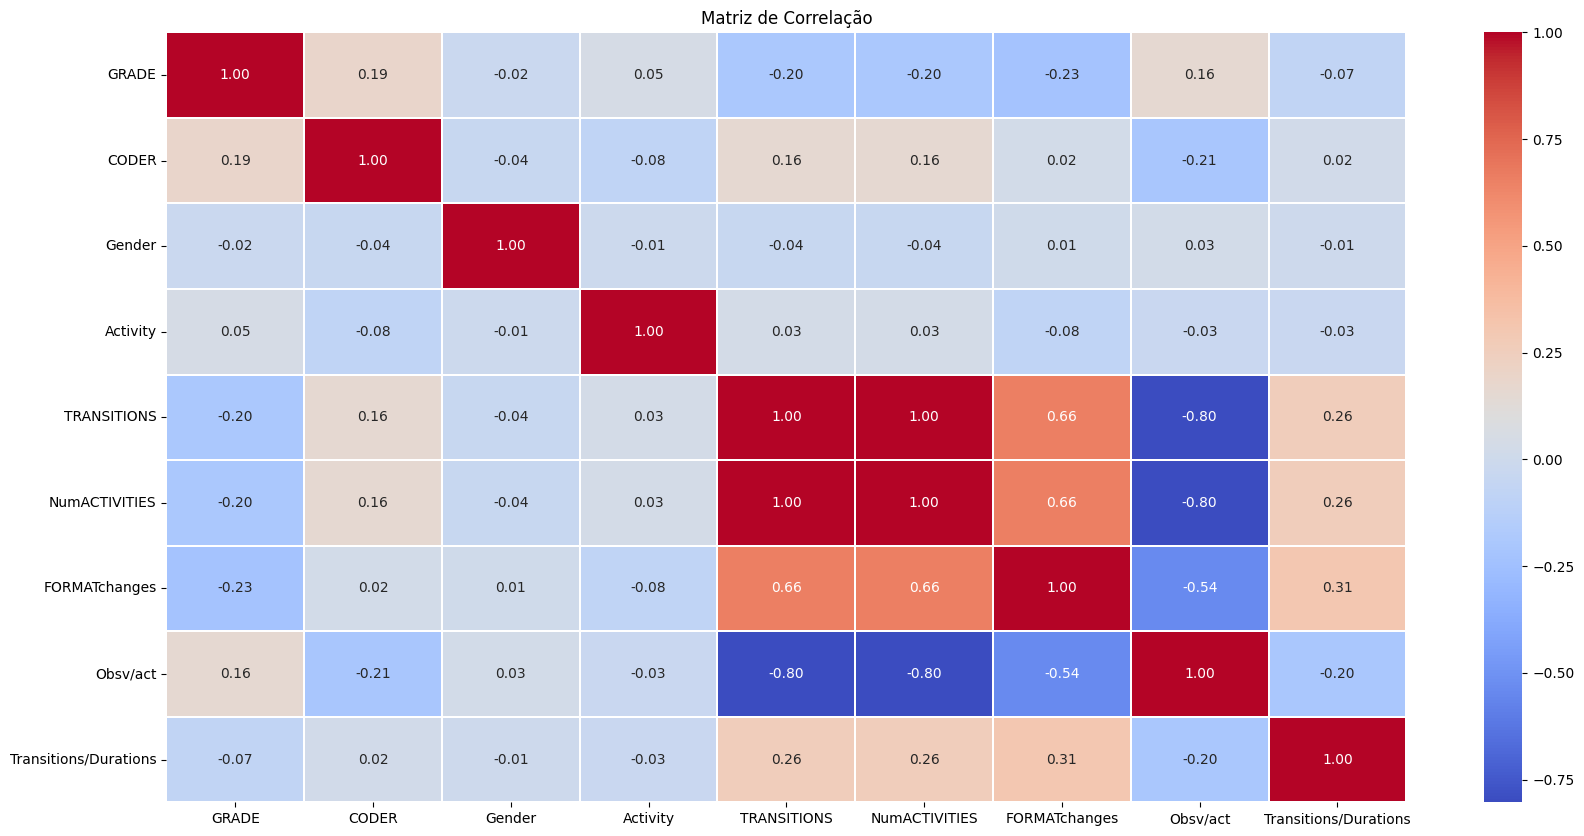

In [192]:
corre = pd.DataFrame(X)

correlation = corre.corr()


plt.figure(figsize=(20, 10))

srn.heatmap(correlation,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.1,
            linecolor='white')

plt.title('Matriz de Correlação')
plt.show()

####Criação de nova feature

######A nova característica transitions_per_activity fornece uma métrica que quantifica a relação entre o número de transições e o número de atividades. Isso pode revelar insights adicionais sobre o comportamento dos dados que não são evidentes apenas ao olhar para TRANSITIONS e NumACTIVITIES separadamente.

In [193]:
X.head(1)

,GRADE,CODER,Gender,Activity,TRANSITIONS,NumACTIVITIES,FORMATchanges,Obsv/act,Transitions/Durations
0,0,1,0,4,3,4,1,770.5,0.004043


In [194]:

X_NewFeature = X.copy()
X_NewFeature['transitions_per_activity'] = X['TRANSITIONS'] / X['NumACTIVITIES']

In [195]:
X_NewFeature.head(1)

,GRADE,CODER,Gender,Activity,TRANSITIONS,NumACTIVITIES,FORMATchanges,Obsv/act,Transitions/Durations,transitions_per_activity
0,0,1,0,4,3,4,1,770.5,0.004043,0.75


In [196]:
X.head(1)

,GRADE,CODER,Gender,Activity,TRANSITIONS,NumACTIVITIES,FORMATchanges,Obsv/act,Transitions/Durations
0,0,1,0,4,3,4,1,770.5,0.004043


###5) Separando o conjunto de dados entre Treino e Teste e inicialização dos Algoritmos - Regressão Logística, SVM e Árvore de Decisão

####Separando o conjunto de dados

In [197]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=35)

In [198]:
X_train.head(5)

,GRADE,CODER,Gender,Activity,TRANSITIONS,NumACTIVITIES,FORMATchanges,Obsv/act,Transitions/Durations
14572,3,1,1,2,4,5,4,460.400000,0.036697
27042,2,1,1,1,4,5,3,524.600000,0.003700
7533,4,1,0,5,0,1,0,2076.000000,0.000000
12676,0,1,1,4,2,3,2,697.666667,0.001742
811,1,1,0,4,1,2,1,1285.000000,0.001479


####Automated Feature Selection

In [199]:
X_train_newFeature, X_test_newFeature, Y_train_newFeature, Y_test_newFeature = train_test_split(X_NewFeature, y, test_size=0.3, random_state=35)


# Definir pré-processadores
numerical_features = X_NewFeature.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_NewFeature.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Configurar o pipeline com DecisionTreeClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Definir a grade de parâmetros para GridSearchCV
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_newFeature, Y_train_newFeature)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['GRADE',
                                                                          'CODER',
                                                                          'Gender',
                                                                          'Activity',
                                                                          'TRANSITIONS',
                                                                          'NumACTIVITIES',
                                                                          'FORMATchanges',
                                                                          'Obsv/act',
                                                                          'Transitions/Durations',
                                                                          'transitions_per_activity']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]})

####Validação Cruzada

In [200]:

num_salpes = 10000
num_features = 5
num_classes = 2

k = 5

kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

models = {
	'Logistic Regression': LogisticRegression(),
	'SVM': svm.SVC(kernel='sigmoid'),
	'Decision Tree': DecisionTreeClassifier()
}

models_scores = {}

for model_name, model in models.items():
	accuracy_scores = cross_val_score(model, X_train, Y_train, cv = kf, scoring = 'accuracy')
	mean_accuracy = np.mean(accuracy_scores)
	models_scores[model_name] = mean_accuracy



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [201]:
best_model_name = max(models_scores, key=models_scores.get)
best_model = models[best_model_name]

print(f'Melhor modelo: {best_model}')

Melhor modelo: DecisionTreeClassifier()


####Justificativa da decisão: Texto de justificativa de qual foi o melhor algoritmo escolhido

R: Árvores de decisão modelam relações não lineares entre os recursos e a variável de destino diretamente, enquanto SVM e Regressão Logística são lineares por natureza e podem necessitar de transformações ou combinações de recursos para lidar com não linearidades. Além disso, as árvores de decisão são robustas contra outliers e dividem o espaço de características em regiões retangulares, reduzindo a sensibilidade a valores discrepantes comparado a métodos como SVM (baseados em distância) e Regressão Logística (baseados em probabilidade).

Diante disso e avaliando os dados de cada coluna do conjunto disponibilizado, observamos não linearidade em várias colunas. Isso dificulta a conversão de modelos como SVM e Regressão Linear, resultando em um desempenho pior que a Árvore de Decisão.

###6) Treinamento com o conjunto de dados completo

####Árvore de Decisão sem Automated Feature Selection

In [202]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

####Árvore de Decisão com Automated Feature Selection

In [203]:
# Avaliar o modelo nos dados de teste
Y_pred_pipeline = grid_search.predict(X_test_newFeature)

##7) Avaliação

####Acurácia, Precisão, Recall e F1 sem Automated Feature Selection

In [204]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f'Acuracia: {accuracy}') # Quantos aprovados e reprovados preditos corretamente
print(f'Precision: {precision}') # Número Total de preditos como aprovados, quantos são mesmo aprovados
print(f'recall: {recall}') # Número total de aprovados na base de dados quantos foram preditos como aprovados
print(f'f1: {f1}') # Média harmônica entre Precisão e Recall

Acuracia: 0.6788461538461539
Precision: 0.6987607244995233
recall: 0.9177249150420318
f1: 0.7934127106850162


####Acurácia, Precisão, Recall e F1 com Automated Feature Selection

In [205]:
# Calcular e imprimir as métricas
accuracy = accuracy_score(Y_test, Y_pred_pipeline)
precision = precision_score(Y_test, Y_pred_pipeline)
recall = recall_score(Y_test, Y_pred_pipeline)
f1 = f1_score(Y_test, Y_pred_pipeline)

print(f'Acuracia: {accuracy}') # Quantos aprovados e reprovados preditos corretamente
print(f'Precision: {precision}') # Número Total de preditos como aprovados, quantos são mesmo aprovados
print(f'recall: {recall}') # Número total de aprovados na base de dados quantos foram preditos como aprovados
print(f'f1: {f1}') # Média harmônica entre Precisão e Recall

Acuracia: 0.6805288461538461
Precision: 0.6982560497498986
recall: 0.9238061169737077
f1: 0.7953495534339391


####Matriz de Confusão sem Automated Feature Selection
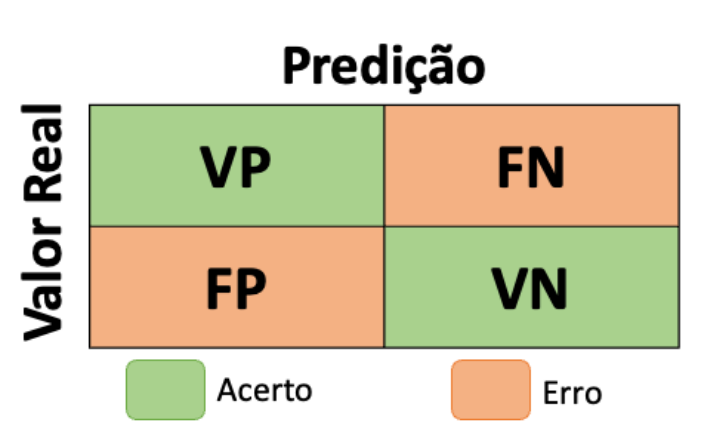

In [206]:
# Calcular a matriz de confusão
cm = confusion_matrix(Y_test, Y_pred)
print("Matriz de Confusão:")
print(cm)

Matriz de Confusão:
[[ 517 2212]
 [ 460 5131]]


* Verdadeiros Positivos (VP): 518

* Falsos Negativos (FN): 2211

* Falsos Positivos (FP): 462

* Verdadeiros Negativos (VN): 5129

####Matriz de Confusão com Automated Feature Selection

In [207]:
cm = confusion_matrix(Y_test, Y_pred_pipeline)
print("Matriz de Confusão:")
print(cm)

Matriz de Confusão:
[[ 497 2232]
 [ 426 5165]]


* Verdadeiros Positivos (VP): 297

* Falsos Negativos (FN): 2432

* Falsos Positivos (FP): 272

* Verdadeiros Negativos (VN): 5319

####Acurácia Balanceada sem Automated Feature Selection

In [208]:
# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(Y_test, Y_pred)
print(f"Acurácia Balanceada: {balanced_acc:.4f}")

Acurácia Balanceada: 0.5536


A acurácia balanceada é a média das taxas de verdadeiros positivos (TPR - True Positive Rate) para cada classe. É uma métrica útil quando as classes são desbalanceadas no conjunto de dados.  A acurácia balanceada 0.5536, indica que, em média, o classificador teve um desempenho moderado em identificar corretamente ambas as classes.

####Acurácia Balanceada com Automated Feature Selection

In [209]:
# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(Y_test, Y_pred_pipeline)
print(f"Acurácia Balanceada: {balanced_acc:.4f}")

Acurácia Balanceada: 0.5530


A acurácia balanceada é a média das taxas de verdadeiros positivos (TPR - True Positive Rate) para cada classe. É uma métrica útil quando as classes são desbalanceadas no conjunto de dados.  A acurácia balanceada 0.5530, indica que, em média, o classificador teve um desempenho moderado em identificar corretamente ambas as classes.

####Coeficiente de Kappa sem Automated Feature Selection

In [210]:
# Calcular o coeficiente Kappa
kappa = cohen_kappa_score(Y_test, Y_pred)
print(f"Kappa: {kappa:.4f}")

Kappa: 0.1282


####Coeficiente de Kappa com Automated Feature Selection

In [211]:
# Calcular o coeficiente Kappa
kappa = cohen_kappa_score(Y_test, Y_pred_pipeline)
print(f"Kappa: {kappa:.4f}")

Kappa: 0.1275


O coeficiente Kappa (κ) é uma métrica que compara o desempenho do classificador com o desempenho esperado por acaso. Ele considera tanto a proporção de acordos observados quanto a proporção de acordos esperados ajustados para o acaso. Um kappa de 0 significa concordância apenas ao acaso, enquanto 1 significa concordância perfeita. Um kappa de 0.1282 indica uma concordância leve além do que seria esperado ao acaso.

####Curva ROC e AUC-ROC

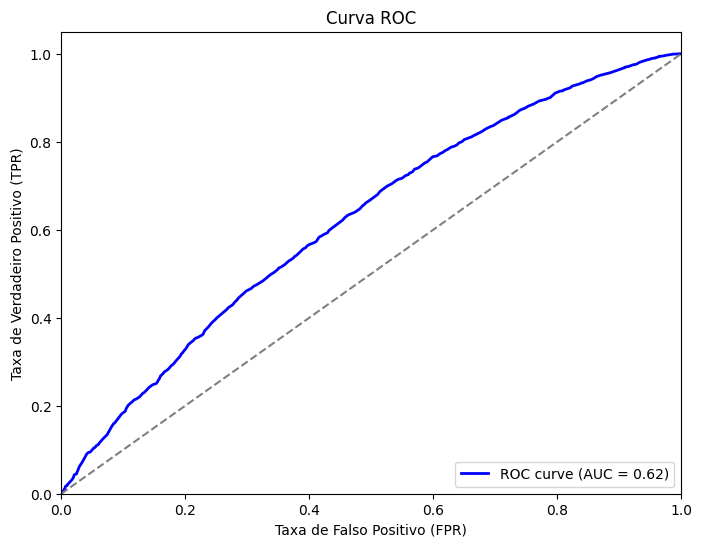

In [212]:
probs = model.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva
fpr, tpr, thresholds = roc_curve(Y_test, probs)
auc_roc = roc_auc_score(Y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

####Curva Precision-Recall e AUC-PR

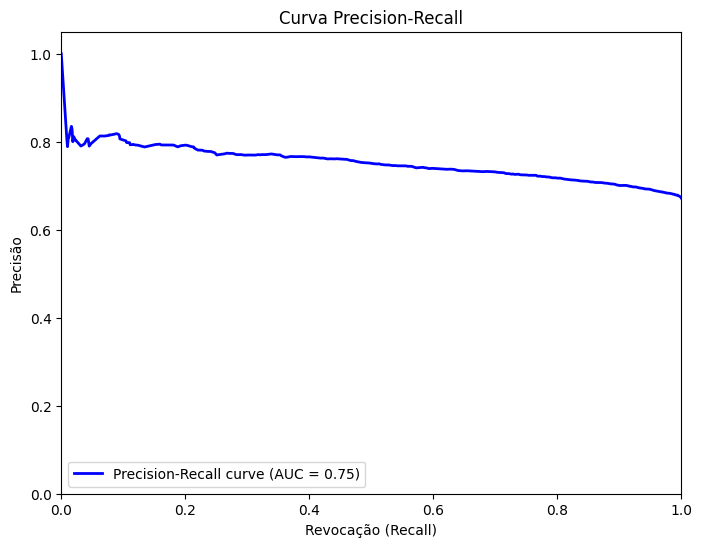

In [213]:
# Calcular a curva Precision-Recall e AUC-PR
precision, recall, _ = precision_recall_curve(Y_test, probs)
auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Revocação (Recall)')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.show()

####Avaliando Overfitting/Underfitting sem Automated Feature Selection

In [214]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Criar o modelo
model = DecisionTreeClassifier()

# Treinar o modelo nos dados de treino
model.fit(X_train, Y_train)

# Prever com base nos dados de treino e teste
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Calcular a acurácia nos dados de treino e teste
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

print(f'Acurácia nos dados de treino: {train_accuracy:.4f}')
print(f'Acurácia nos dados de teste: {test_accuracy:.4f}')

Acurácia nos dados de treino: 0.6917
Acurácia nos dados de teste: 0.6787


####Avaliando Overfitting/Underfitting com Automated Feature Selection

In [216]:
# Obter previsões com o melhor modelo encontrado pelo GridSearchCV
# Previsões para dados de treino
Y_train_pred = grid_search.predict(X_train_newFeature)

# Previsões para dados de teste
Y_test_pred = grid_search.predict(X_test_newFeature)

# Calcular a acurácia nos dados de treino e teste
train_accuracy = accuracy_score(Y_train_newFeature, Y_train_pred)
test_accuracy = accuracy_score(Y_test_newFeature, Y_test_pred)

print(f'Acurácia nos dados de treino: {train_accuracy:.4f}')
print(f'Acurácia nos dados de teste: {test_accuracy:.4f}')

Acurácia nos dados de treino: 0.6900
Acurácia nos dados de teste: 0.6805


###Discussão

Análise Comparativa

* Acurácia: Acurácia ligeiramente melhorada com a nova feature, de 67.88% para 68.05%. Isso indica que a nova característica pode ter contribuído para uma ligeira melhoria no número total de previsões corretas.

* Precisão: A precisão caiu ligeiramente, o que significa que uma proporção menor das previsões positivas são corretas. Pode indicar um aumento em falsos positivos.

* Recall: Aumentou com a nova característica, indicando que o modelo agora identifica mais casos positivos verdadeiros.

* F1-Score: Melhorou com a nova característica, o que é uma boa notícia pois reflete um melhor equilíbrio entre precisão e recall.

* Acurácia Balanceada e Kappa: Mantêm-se semelhantes ou com pequenas mudanças. A acurácia balanceada sugere que, apesar da nova característica, o desequilíbrio entre as classes não mudou significativamente.

* O Kappa continua baixo, indicando um acordo ainda limitado entre as previsões e as verdadeiras observações.

Conclusão

A nova característica transitions_per_activity parece ter um impacto positivo na métrica F1-Score e Recall, mas uma leve redução na Precisão e Acurácia Balanceada. A mudança na Acurácia é pequena, mas o aumento no Recall indica que o modelo está melhor em identificar casos positivos.

A melhoria no F1-Score sugere que, no geral, a nova característica ajudou a equilibrar melhor a precisão e o recall. No entanto, o Kappa sugere que o modelo ainda está apenas marginalmente melhor que o acaso.

##8) Seleção de features usando o método Recursive Feature Elimination (RFE).

In [217]:
# Definir as características numéricas e categóricas
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [218]:
# Configurar pré-processadores para variáveis numéricas e categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Configurar o pipeline com RFE e DecisionTreeClassifier
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=model)),  # Seleção de características com RFE
    ('classifier', model)
])


In [219]:
# Configurar GridSearchCV para otimização de hiperparâmetros
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15],  # Ajuste conforme o número de características
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [220]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Obter previsões com o melhor modelo encontrado pelo GridSearchCV
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Calcular e imprimir as métricas
train_accuracy = accuracy_score(Y_train, y_train_pred)
test_accuracy = accuracy_score(Y_test, y_test_pred)

print(f'Acurácia nos dados de treino: {train_accuracy:.4f}')
print(f'Acurácia nos dados de teste: {test_accuracy:.4f}')

Acurácia nos dados de treino: 0.6900
Acurácia nos dados de teste: 0.6805


**Acurácia nos dados de treino (0.6900)**: Esta é a acurácia calculada com base nos dados que o modelo viu durante o treinamento. Ela indica o quão bem o modelo se ajustou aos dados de treino. A acurácia de 0.6900 sugere que o modelo conseguiu classificar corretamente cerca de 69.00% das amostras no conjunto de treino.


**Acurácia nos dados de teste (0.6805)**: Esta é a acurácia calculada usando dados que o modelo nunca viu durante o treinamento, servindo como uma avaliação independente do desempenho do modelo. A acurácia de 0.6805 indica que o modelo classificou corretamente cerca de 68.05% das amostras no conjunto de teste.

Com base nas acurácias obtidas, o modelo não está sofrendo de overfitting, uma vez que a diferença entre as acurácias de treino e teste não é grande. No entanto, também não há underfitting, já que as acurácias em ambos os conjuntos de dados são relativamente altas. O modelo está razoavelmente bem ajustado aos dados, com uma performance consistente entre treino e teste.

####Acurácia, Precisão, Recall e F1 com RFE

In [221]:
# Calcular e imprimir as métricas
accuracy = accuracy_score(Y_test, y_test_pred)
precision = precision_score(Y_test, y_test_pred)
recall = recall_score(Y_test, y_test_pred)
f1 = f1_score(Y_test, y_test_pred)

print(f'Acuracia: {accuracy}') # Quantos aprovados e reprovados preditos corretamente
print(f'Precision: {precision}') # Número Total de preditos como aprovados, quantos são mesmo aprovados
print(f'recall: {recall}') # Número total de aprovados na base de dados quantos foram preditos como aprovados
print(f'f1: {f1}') # Média harmônica entre Precisão e Recall

Acuracia: 0.6805288461538461
Precision: 0.6982560497498986
recall: 0.9238061169737077
f1: 0.7953495534339391


####Matriz de Confusão com RFE

In [222]:
cm = confusion_matrix(Y_test, y_test_pred)
print("Matriz de Confusão:")
print(cm)

Matriz de Confusão:
[[ 497 2232]
 [ 426 5165]]


* Verdadeiros Positivos (VP): 497

* Falsos Negativos (FN): 2232

* Falsos Positivos (FP): 426

* Verdadeiros Negativos (VN): 5165

####Acurácia Balanceada com RFE

In [223]:
# Calcular a acurácia balanceada
balanced_acc = balanced_accuracy_score(Y_test, y_test_pred)
print(f"Acurácia Balanceada: {balanced_acc:.4f}")

Acurácia Balanceada: 0.5530


A acurácia balanceada é a média das taxas de verdadeiros positivos (TPR - True Positive Rate) para cada classe. É uma métrica útil quando as classes são desbalanceadas no conjunto de dados.  A acurácia balanceada 0.5530, indica que, em média, o classificador teve um desempenho moderado em identificar corretamente ambas as classes.

####Coeficiente de Kappa com RFE

In [224]:
# Calcular o coeficiente Kappa
kappa = cohen_kappa_score(Y_test, y_test_pred)
print(f"Kappa: {kappa:.4f}")

Kappa: 0.1275


###Discussão

Impacto da Nova Feature:

* A nova característica aparentemente não teve impacto nas métricas de avaliação. Isso pode indicar que a característica transitions_per_activity não adicionou informação útil para a melhoria do modelo ou não foi suficientemente informativa para alterar o desempenho.

Verificação da Nova Feature:

*  É possível que a nova característica transitions_per_activity não seja relevante para o modelo ou que sua influência seja marginal.